# UK energy data

From: https://www.gridwatch.templar.co.uk/download.php

> The CSV file and show the energy (MW, I believe) demand, generation (split by source) and import/export (split by country). The granularity is approximately 5 minute increments so we'll likely want to average to a timescale that matches our other data whilst being mindful of the fact that the timestamps are non-constant.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import requests
import os
import numpy as np
from scipy import integrate

In [2]:
# Go to repository root directory
if "_changed_dir" not in locals():
    os.chdir("../")
    _changed_dir = True

## Data load

In [3]:
raw_data_dir = 'data/raw'
if not os.path.exists(raw_data_dir):
    os.makedirs(raw_data_dir)

In [4]:
file_name = 'uk_energy_trends.csv'

file_path = os.path.join(raw_data_dir, file_name)

## Preprocess data

In [5]:
uk_energy = pd.read_csv(file_path)
new_names = {x:x if x[0]!=' ' else x[1:] for x in uk_energy.columns} # drop leading spaces
uk_energy.rename(columns = new_names, inplace=True)
uk_energy.drop(columns = ['id', 'frequency'], inplace=True) # drop useless columns
uk_energy.drop(columns = ['french_ict', 'dutch_ict', 'irish_ict',
                          'ew_ict', 'nemo'], inplace=True) # drop international import/export
uk_energy.drop(columns = ['north_south',
                          'scotland_england'], inplace=True) # drop intranational import/export
uk_energy["timestamp"] = pd.to_datetime(uk_energy["timestamp"])
uk_energy.set_index(["timestamp"], inplace=True)

In [6]:
uk_energy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 888456 entries, 2012-01-01 00:00:01 to 2020-06-18 23:35:34
Data columns (total 12 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   demand   888456 non-null  int64  
 1   coal     888456 non-null  int64  
 2   nuclear  888456 non-null  int64  
 3   ccgt     888456 non-null  int64  
 4   wind     888456 non-null  int64  
 5   pumped   888456 non-null  int64  
 6   hydro    888456 non-null  int64  
 7   biomass  888456 non-null  int64  
 8   oil      888456 non-null  int64  
 9   solar    888456 non-null  float64
 10  ocgt     888456 non-null  int64  
 11  other    888456 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 88.1 MB


In [7]:
uk_energy.head()

,demand,coal,nuclear,ccgt,wind,pumped,hydro,biomass,oil,solar,ocgt,other
timestamp,,,,,,,,,,,,
2012-01-01 00:00:01,30590,8693,7121,8568,2740,0,728,0,0,0.0,0,0
2012-01-01 00:05:06,30490,8650,7120,8441,2812,0,732,0,0,0.0,0,0
2012-01-01 00:10:01,30802,8880,7125,8427,2896,0,744,0,0,0.0,0,0
2012-01-01 00:15:01,31180,9111,7122,8494,2964,0,748,0,0,0.0,0,0
2012-01-01 00:20:01,31241,9195,7114,8449,2992,0,750,0,0,0.0,0,0


In [8]:
uk_energy.describe()

,demand,coal,nuclear,ccgt,wind,pumped,hydro,biomass,oil,solar,ocgt,other
count,888456.000000,888456.000000,888456.000000,888456.000000,888456.000000,888456.000000,888456.000000,888456.000000,888456.000000,8.884560e+05,888456.000000,888456.000000
mean,33037.299407,6831.015766,7078.314251,11460.306365,3262.797762,290.134386,411.133311,1285.070740,0.480499,5.193149e+02,2.654882,30.297970
std,7289.912038,6417.973124,1009.565937,5204.303311,2611.238182,333.045134,254.816369,792.727786,16.834022,2.542033e+03,22.027599,52.248356
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,27329.000000,799.000000,6461.000000,7228.000000,1239.000000,0.000000,200.000000,710.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,32382.000000,4987.000000,7238.000000,11187.000000,2569.000000,285.000000,376.000000,1216.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,38187.000000,12311.000000,7830.000000,15117.000000,4591.000000,426.000000,588.000000,2009.000000,0.000000,5.890000e-01,0.000000,63.000000
max,254852.000000,25239.000000,9346.000000,27163.000000,13761.000000,2861.000000,1434.000000,3217.000000,1299.000000,1.420000e+06,990.000000,1063.000000


In [9]:
uk_energy.isnull().values.any()

False

In [10]:
print(f"Data in range: {uk_energy.index.min()} to {uk_energy.index.max()}")

Data in range: 2012-01-01 00:00:01 to 2020-06-18 23:35:34


## Average for each day

The data available is too granular so will need to be aggregated, most likely to the day level, to align with other datasets. As the timestamps are not consistent taking the mean of the data points is not appropriate.

In [11]:
uk_energy.groupby(pd.Grouper(freq='D')).mean().head() # sanity check for integration calcs

,demand,coal,nuclear,ccgt,wind,pumped,hydro,biomass,oil,solar,ocgt,other
timestamp,,,,,,,,,,,,
2012-01-01,31914.652778,8501.128472,7047.003472,9822.274306,2640.236111,394.107639,786.402778,0.0,0.0,0.0,0.000000,0.0
2012-01-02,34677.912892,10203.655052,7075.986063,11222.003484,2762.261324,326.686411,777.780488,0.0,0.0,0.0,0.000000,0.0
2012-01-03,40226.892361,15384.989583,6964.746528,12183.840278,2159.430556,325.079861,804.246528,0.0,0.0,0.0,0.000000,0.0
2012-01-04,41752.642361,17026.888889,7079.906250,11425.777778,2654.190972,370.715278,806.322917,0.0,0.0,0.0,0.000000,0.0
2012-01-05,41370.364583,16545.250000,7540.791667,10884.895833,2639.517361,375.489583,827.434028,0.0,0.0,0.0,7.736111,0.0


In [12]:
def integrate_day(group):
    return integrate.trapz(group, x=group.index
                          )/(group.index.max()-group.index.min())

uk_energy_daily = uk_energy.groupby(pd.Grouper(freq='D')).aggregate(integrate_day)

In [13]:
uk_energy_daily.head()

,demand,coal,nuclear,ccgt,wind,pumped,hydro,biomass,oil,solar,ocgt,other
timestamp,,,,,,,,,,,,
2012-01-01,31921.377109,8503.326566,7046.980315,9825.443255,2640.209262,395.433407,786.557070,0.0,0.0,0.0,0.000000,0.0
2012-01-02,34732.126852,10224.008780,7076.118455,11249.680447,2763.434292,330.834843,778.479930,0.0,0.0,0.0,0.000000,0.0
2012-01-03,40255.175892,15400.268417,6964.246600,12198.865402,2157.367075,326.300304,804.499379,0.0,0.0,0.0,0.000000,0.0
2012-01-04,41781.346488,17043.294210,7079.408358,11437.829282,2654.619125,372.046767,806.543498,0.0,0.0,0.0,0.000000,0.0
2012-01-05,41395.873965,16557.258353,7540.756814,10895.422977,2641.025154,377.263695,827.706123,0.0,0.0,0.0,7.763538,0.0


In [14]:
uk_energy_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3092 entries, 2012-01-01 to 2020-06-18
Freq: D
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   demand   3092 non-null   float64
 1   coal     3092 non-null   float64
 2   nuclear  3092 non-null   float64
 3   ccgt     3092 non-null   float64
 4   wind     3092 non-null   float64
 5   pumped   3092 non-null   float64
 6   hydro    3092 non-null   float64
 7   biomass  3092 non-null   float64
 8   oil      3092 non-null   float64
 9   solar    3092 non-null   float64
 10  ocgt     3092 non-null   float64
 11  other    3092 non-null   float64
dtypes: float64(12)
memory usage: 314.0 KB


## Plotting data

In [15]:
# uk_energy.plot()
# plt.ylabel('Power [MW]')

Text(0, 0.5, 'Power [MW]')

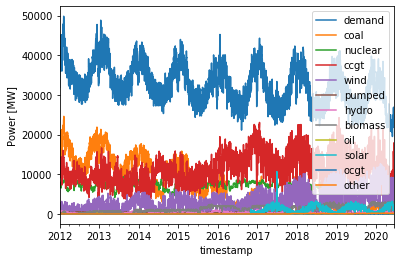

In [16]:
uk_energy_daily.plot()
plt.ylabel('Power [MW]')

Text(0, 0.5, 'Power [MW]')

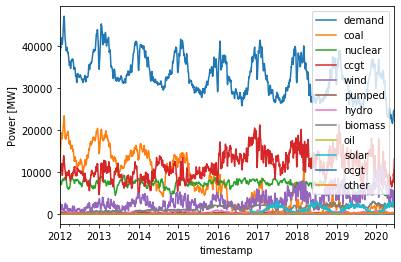

In [17]:
uk_energy_daily.rolling('7D').mean().plot()
plt.ylabel('Power [MW]')

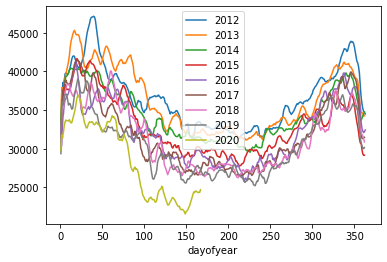

In [18]:
uk_energy_daily["dayofyear"] = uk_energy_daily.index.dayofyear
fig, axs = plt.subplots()
for year in uk_energy_daily.index.year.unique():
    year = str(year)
    uk_energy_daily[year].rolling('7D').mean().plot(
        x="dayofyear", y="demand", ax=axs, label=year)

## Output processed data


In [19]:
proc_data_dir = 'data/processed'
if not os.path.exists(proc_data_dir):
    os.makedirs(proc_data_dir)

In [20]:
file_name = 'uk_energy_daily.csv'
file_path = os.path.join(proc_data_dir, file_name)

In [21]:
uk_energy_daily.to_csv(file_path)